# RIEML DCC MODEL to GRU
> Created July. 2025 <br>
> Nikhil Bisht<br>

# Definitions

In [1]:
# standard system modules
import os, sys
import h5py 
import argparse
# standard module for tabular data
import pandas as pd
import json

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp
import skimage as ski

# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image

from tqdm import tqdm
import random
import time
import plot
import datetime

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/rieml/tubes_take8_time.h5'
MODELFILE = 'nnmodel.dict'

TEST_PERCENTAGE = 0.2

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')

idd = 402
what = "317+401 All the bells and time."

Available device: cpu 


# Functions

In [ ]:
def init_weights_constant(m):
    if isinstance(m, nn.Linear):
        #nn.init.constant_(m.weight, 0.5)
        nn.init.constant_(m.bias, 0.1)

def thisnet():
    hidden_dims = 1024,1024
    conv_channels = 128
    model = main_net(hidden_dims=hidden_dims, conv_channels=conv_channels)
    return model

def train(model,data,parameters, validatedata, validateparams):
    epochs = 300000
    lr = 1e-3
    batch_size=3
    trainer(model,data,parameters,validatedata,validateparams,epochs=epochs,lr=lr,batch_size=batch_size)

def trainer(model, x_train ,y_train, x_validate, y_validate, epochs=1, lr=1e-3, batch_size=10, test_num=0, weight_decay=None):
    optimizer = optim.AdamW( model.parameters(), lr=lr,weight_decay =weight_decay )
    from torch.optim.lr_scheduler import CyclicLR
    scheduler = CyclicLR(
            optimizer,
            base_lr=1e-7,
            max_lr=1e-3,
            step_size_up=30000,
            mode='triangular',   # or 'triangular2', 'exp_range'
            cycle_momentum=False # if you use Adam, turn this off
    )
    losses=[]
    a = torch.arange(len(data))
    N = len(data)
    seed = 8675309
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


    t0 = time.time()
    minlist=[];meanlist=[];maxlist=[];stdlist=[]
    for epoch in range(epochs):
        subset = torch.tensor(random.sample(list(a),batch_size))
        data_subset =  data[subset]
        param_subset = parameters[subset]
        optimizer.zero_grad()
        output1=model(param_subset)
        loss = model.criterion(output1, data_subset)
        loss.backward()
        optimizer.step()
        scheduler.step()
        tnow = time.time()
        tel = tnow-t0
        if (epoch>0 and epoch%100==0) or epoch==10:
            model.eval()
            validate_losses = plot.compute_losses(model, validatedata, validateparams)
            model.train()

            time_per_epoch = tel/epoch
            epoch_remaining = epochs-epoch
            time_remaining_s = time_per_epoch*epoch_remaining
            eta = tnow+time_remaining_s
            etab = datetime.datetime.fromtimestamp(eta)

            if 1:
                hrs = time_remaining_s//3600
                minute = (time_remaining_s-hrs*3600)//60
                sec = (time_remaining_s - hrs*3600-minute*60)#//60
                time_remaining="%02d:%02d:%02d"%(hrs,minute,sec)
            if 1:
                eta = "%0.2d:%0.2d:%0.2d"%(etab.hour, etab.minute, int(etab.second))

            mean = validate_losses.mean()
            std = validate_losses.std()
            mmin = validate_losses.min()
            mmax = validate_losses.max()
            minlist.append(mmin)
            maxlist.append(mmax)
            meanlist.append(mean)
            stdlist.append(std)
            print("test%d %d L %0.2e LR %0.2e left %8s  eta %8s loss mean %0.2e var %0.2e min %0.2e max %0.2e"%
                  (idd,epoch,loss, optimizer.param_groups[0]['lr'],time_remaining, eta, mean, std, mmin, mmax))
            loss_batch=[]
    print("Run time", tel)
    plt.clf()
    plt.plot(meanlist,c='k')
    plt.plot(np.array(meanlist)+np.array(stdlist),c='b')
    plt.plot(np.array(meanlist)-np.array(stdlist),c='b')
    plt.plot(minlist,c='r')
    plt.plot(maxlist,c='r')
    plt.yscale('log')
    plt.savefig('./plots/errortime_test%d'%(idd))
    plt.clf()


class main_net(nn.Module):
    def __init__(self, output_length=1000, hidden_dims=(128, 128), conv_channels=32, characteristic=False):
        super().__init__()
        self.output_length = output_length

        # Project 6 input values to a pseudo-spatial format (3 channels)
        self.fc1 = nn.Linear(7, 3 * output_length)
        self.relu1 = nn.ReLU()

        # Conv block 1 (acts on the "3 x output_length" format)
        dil = 1
        kern = 5
        padding = dil*(kern-1)//2
        dil2 = 2
        padding2 = dil2*(kern-1)//2
        dil3 = 4
        padding3 = dil3*(kern-1)//2
        dil4 = 8
        padding4 = dil4*(kern-1)//2
        self.conv1 = nn.Sequential(
            nn.Conv1d(3, conv_channels, kernel_size=kern, padding=padding, dilation=dil),
            nn.ReLU(),
            nn.Conv1d(conv_channels, 3, kernel_size=kern, padding=padding, dilation=dil),
            nn.ReLU()
        )

        # FC block 2: merge spatial info
        if 1:
            in_dim = 3*output_length
            out_dim = 3*output_length
            layers=[]
            dims = [in_dim] + list(hidden_dims) + [out_dim]
            for i in range(len(dims)-1):
                layers.append(nn.Linear(dims[i], dims[i+1]))
                if i < len(dims) - 2:
                    layers.append(nn.ReLU())
            self.fc2 = nn.Sequential(*layers)

        # Conv block 2
        dil = 1
        kern = 3
        padding = dil*(kern-1)//2
        self.conv2 = nn.Sequential(
            nn.Conv1d(3, conv_channels, kernel_size=kern, padding=padding, dilation=dil),
            nn.ReLU(),
            nn.Conv1d(conv_channels, 3, kernel_size=kern, padding=padding, dilation=dil)
        )
        dil1 = 2
        kern1 = 3
        padding1 = dil1*(kern1-1)//2
        dil2 = 2
        kern2 = 3
        padding2 = dil2*(kern2-1)//2
        dil3 = 5
        kern3 = 7
        padding3 = dil3*(kern3-1)//2
        if 1:
            self.conv3a = nn.Sequential(
                nn.Conv1d(3, conv_channels, kernel_size=kern1, padding=padding1, dilation=dil1),
                nn.ReLU())
            self.conv3b = nn.Sequential(
                nn.Conv1d(conv_channels, 2*conv_channels, kernel_size=kern2, padding=padding2, dilation=dil2),
                nn.ReLU())
            self.conv3c = nn.Sequential(
                nn.Conv1d(2*conv_channels, 4*conv_channels, kernel_size=kern3, padding=padding3, dilation=dil3),
                nn.ReLU())
            self.conv3d = nn.Sequential(
                nn.Conv1d(4*conv_channels, 2*conv_channels, kernel_size=kern3, padding=padding3, dilation=dil3),
                nn.ReLU())
            self.conv3e = nn.Sequential(
                nn.Conv1d(2*conv_channels, conv_channels, kernel_size=kern2, padding=padding2, dilation=dil2),
                nn.ReLU())
            self.convdone = nn.Sequential(
                nn.Conv1d(conv_channels, 3, kernel_size=kern1, padding=padding1, dilation=dil1)
            )
        self.conv1.apply(init_weights_constant)
        self.conv2.apply(init_weights_constant)
        self.conv3a.apply(init_weights_constant)
        self.conv3b.apply(init_weights_constant)
        self.conv3c.apply(init_weights_constant)
        self.conv3d.apply(init_weights_constant)
        self.conv3e.apply(init_weights_constant)
        self.convdone.apply(init_weights_constant)
        self.fc2.apply(init_weights_constant)
        self.fc1.apply(init_weights_constant)
        self.T = nn.Parameter(torch.eye(3) + 0.01 * torch.randn(3, 3)) 

        self.mse=nn.MSELoss()
        self.log_derivative_weight = nn.Parameter(torch.tensor(0.0)) 
        embed_dim=output_length
        num_heads = 4
        self.hl = nn.HuberLoss(delta=0.2)
        self.l1 = nn.L1Loss()

    def criterion(self,guess,target, initial=None):
        L1 = self.l1(target,guess)
        return L1

    def forward(self, x):
        batch_size=x.shape[0]
        # FC1 to expand global features into spatial representation
        x = self.fc1(x)  # (batch_size, 3*output_length)
        x = self.relu1(x)
        x = x.view(batch_size, 3, self.output_length)  # shape (B, 3, L)

        if 0:
            rho, vel, pres = torch.chunk(x, 3, dim=1)
            rho, weights = self.attn_rho(rho,rho,rho)
            vel, weights = self.attn_vel(vel,vel,vel)
            pres, weights=self.attn_pres(pres,pres,pres)
            x = torch.cat([rho, vel, pres], dim=1)

        # Conv block 1: local patterns
        x = x + self.conv1(x)  # Residual connection

        # FC2 block: reprocess globally
        x_flat = x.view(batch_size, -1)
        x_flat = self.fc2(x_flat)
        x = x_flat.view(batch_size,3, self.output_length)
        #x = self.attn(x)

        # Conv block 2: refine locally again
        x = x + self.conv2(x)
        #conv 3
        x1 = self.conv3a(x)
        x2 = self.conv3b(x1)
        x3 = self.conv3c(x2)
        x4 =x2+ self.conv3d(x3)
        x5 =x1+ self.conv3e(x4)
        z = x+self.convdone(x5)
        

        return z  # shape (B, 3, output_length)


# Visualize Model

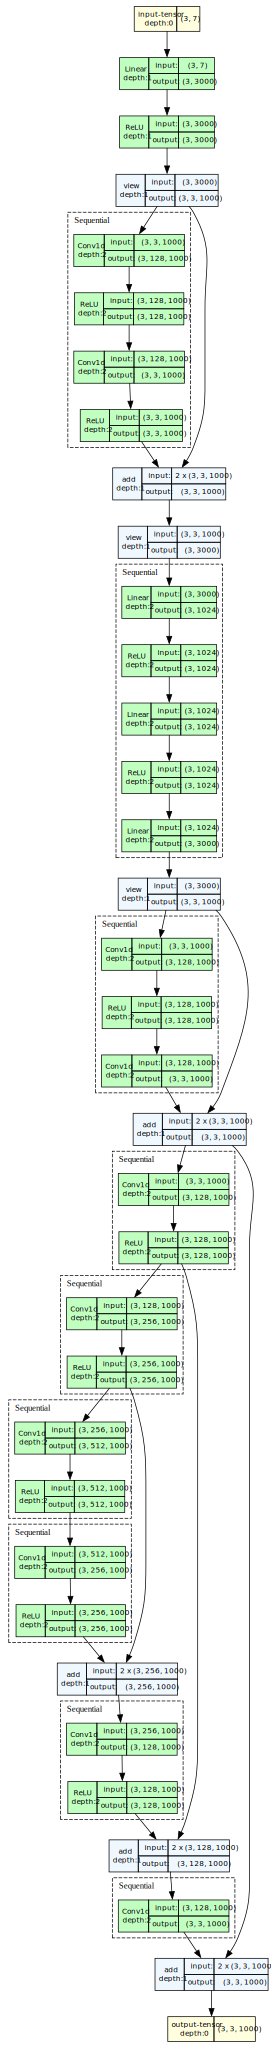

In [3]:
from torchview import draw_graph

model = thisnet()
batch_size = 3
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(batch_size,7), device='meta', expand_nested=True, depth=3)
model_graph.visual_graph

# Load Images

In [97]:
from importlib import reload
import plot
reload(plot)

import tube_loader

testnum=idd

def get_data(seq = 3, nvalid=50, ntest=100):
    rieml_data, parameters= tube_loader.read_all_parameters(DATAFILE)
    reshaped_data = rieml_data.reshape(3000,11,3,1000)
    sequenced_data = np.array([]).reshape(0,3,3,1000)
    for i in range(11-seq+1):
        sequenced_data = np.concatenate((sequenced_data,reshaped_data[:,i:i+seq,:,:]), axis=0)
    #shuffle dataset
    shuffled_indices = torch.randperm(sequenced_data.shape[0])
    sequenced_data_shuffled = torch.index_select(torch.from_numpy(sequenced_data), dim=0, index=shuffled_indices)
    len_seq = sequenced_data_shuffled.shape[0]
    ntrain = len_seq-nvalid-ntest
    # Split the tensor
    train_dataset, test_dataset, validation_dataset = torch.split(sequenced_data_shuffled, [ntrain,ntest,nvalid], dim=0)
    X = {'train': train_dataset[:,0:2,:,:], 'test': test_dataset[:,0:2,:,:], 'validate': validation_dataset[:,0:2,:,:]}
    y = {'train': train_dataset[:,2,:,:][:, None, :, :], 'test': test_dataset[:, None, :, :], 'validate': validation_dataset[:, None, :, :]}
    return X,y

rieml_data_seq, parameters_seq = get_data(seq = 3, nvalid=50, ntest=100)

# Train Model

In [ ]:
new_model = 1
load_model = 0
train_model = 1

if new_model:
    model = thisnet()

if load_model:
    model.load_state_dict(torch.load("models/test%d.pth"%idd))

total_time='no'
if train_model:
    t0 = time.time()

    train(model,rieml_data_seq['train'],parameters_seq['train'], rieml_data_seq['validate'],parameters_seq['validate'])

    t1 = time.time() - t0
    hrs = t1//3600
    minute = (t1-hrs*3600)//60
    sec = (t1 - hrs*3600-minute*60)#//60
    total_time="%02d:%02d:%02d"%(hrs,minute,sec)

if 1:
    print('losses')
    loss_train = plot.compute_losses(model, rieml_data_seq['train'],parameters_seq['train'])
    loss_test = plot.compute_losses(model, rieml_data_seq['test'],parameters_seq['test'])
    loss_validate = plot.compute_losses(model, rieml_data_seq['validate'],parameters_seq['validate'])
    args_train = torch.argsort(loss_train)
    args_test = torch.argsort(loss_test)
    #args_validate = torch.argsort(loss_validate)
if 1:
    print('plot')
    plot.plot_hist(loss_train,loss_test,loss_validate,idd)

    zzz=plot.test_plot(rieml_data_seq['test'][args_test[:5]], parameters_seq['test'][args_test[:5]], model, fname="test%d_test_best"%testnum)
    zzz=plot.test_plot(rieml_data_seq['test'][args_test[-5:]], parameters_seq['test'][args_test[-5:]], model, fname="test%d_test_worst"%testnum)
    zzz=plot.test_plot(rieml_data_seq['train'][args_train[:5]], parameters_seq['train'][args_train[:5]], model, fname="test%d_train_best"%testnum)
    zzz=plot.test_plot(rieml_data_seq['train'][args_train[-5:]], parameters_seq['train'][args_train[-5:]], model, fname="test%d_train_worst"%testnum)
    zzz=plot.test_plot(rieml_data_seq['validate'], parameters_seq['validate'], model, fname="test%04d_avalidate"%testnum)

if not load_model:
    nparam = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model test{testnum:d} with {nparam:,d} parameters elapsed {total_time:s}")
    oname = "models/test%d.pth"%testnum
    torch.save(model.state_dict(), oname)
    print("model saved ",oname)

test292 Epoch 5000 loss 2.22e-01 LR 1.00e-04 time left 00:14:57 loss mean 4.84e-01 var 1.52e-01 min 1.52e-01 max 7.46e-01


# Documentation for different metrics
[scikit-image documentation](https://scikit-image.org/docs/0.25.x/api/skimage.metrics.html#module-skimage.metrics)

In [23]:
def plot_comparison(input_arr, pred_output_arr, act_output_arr, label, save_filename='xy_data.png', dont_show = False):
    input_str = 'INPUT IMAGE:\n'
    pred_str = 'PREDICTED IMAGE:\n'
    act_str = 'ACTUAL IMAGE:\n'
    # Calculate metrics
    input_MSE = ski.metrics.mean_squared_error(act_output_arr, input_arr)
    input_str+= 'MSE: '+'{:0.5f}'.format(input_MSE)+'\n'
    pred_MSE = ski.metrics.mean_squared_error(act_output_arr, pred_output_arr)
    pred_str+= 'MSE: '+'{:0.5f}'.format(pred_MSE)+'\n'
    actual_MSE = ski.metrics.mean_squared_error(act_output_arr, act_output_arr)
    act_str+= 'MSE: '+'{:0.5f}'.format(actual_MSE)+'\n'

    input_NMI = ski.metrics.normalized_mutual_information(act_output_arr, input_arr, bins=100)
    input_str+= 'NMI: '+'{:0.5f}'.format(input_NMI)+'\n'
    pred_NMI = ski.metrics.normalized_mutual_information(act_output_arr, pred_output_arr, bins=100)
    pred_str+= 'NMI: '+'{:0.5f}'.format(pred_NMI)+'\n'
    actual_NMI = ski.metrics.normalized_mutual_information(act_output_arr, act_output_arr, bins=100)
    act_str+= 'NMI: '+'{:0.5f}'.format(actual_NMI)+'\n'

    inversed_input_arr = img_inverse_transform(input_arr)
    inversed_pred_output_arr = img_inverse_transform(pred_output_arr)
    inversed_act_output_arr = img_inverse_transform(act_output_arr)
    input_PSNR = ski.metrics.peak_signal_noise_ratio(inversed_act_output_arr, inversed_input_arr, data_range=np.max(inversed_input_arr) - np.min(inversed_input_arr))
    input_str+= 'PSNR: '+'{:0.5f}'.format(input_PSNR)+'\n'
    pred_PSNR = ski.metrics.peak_signal_noise_ratio(inversed_act_output_arr, inversed_pred_output_arr, data_range=np.max(inversed_pred_output_arr) - np.min(inversed_pred_output_arr))
    pred_str+= 'PSNR: '+'{:0.5f}'.format(pred_PSNR)+'\n'
    actual_PSNR = ski.metrics.peak_signal_noise_ratio(inversed_act_output_arr, inversed_act_output_arr, data_range=np.max(inversed_act_output_arr) - np.min(inversed_act_output_arr))
    act_str+= 'PSNR: '+'{:0.5f}'.format(actual_PSNR)+'\n'

    input_SSI = ski.metrics.structural_similarity(act_output_arr, input_arr, gradient=False, data_range=np.max(input_arr) - np.min(input_arr), channel_axis=None)
    input_str+= 'SSI: '+'{:0.5f}'.format(input_SSI)+'\n'
    pred_SSI = ski.metrics.structural_similarity(act_output_arr, pred_output_arr, gradient=False, data_range=np.max(pred_output_arr) - np.min(pred_output_arr), channel_axis=None)
    pred_str+= 'SSI: '+'{:0.5f}'.format(pred_SSI)+'\n'
    actual_SSI = ski.metrics.structural_similarity(act_output_arr, act_output_arr, gradient=False, data_range=np.max(act_output_arr) - np.min(act_output_arr), channel_axis=None)
    act_str+= 'SSI: '+'{:0.5f}'.format(actual_SSI)+'\n'

    input_total_density = np.sum(inversed_input_arr)
    input_str+= 'Total Density: '+'{:0.5f}'.format(input_total_density)+'\n'
    pred_total_density = np.sum(inversed_pred_output_arr)
    pred_str+= 'Total Density: '+'{:0.5f}'.format(pred_total_density)+'\n'
    act_total_density = np.sum(inversed_act_output_arr)
    act_str+= 'Total Density: '+'{:0.5f}'.format(act_total_density)+'\n'

    fig = plt.figure(figsize=(12, 12))
    
    for i in range(3):
        ax  = fig.add_subplot(3, 3, 3*i+1)
        c = ax.pcolormesh(np.mean(input_arr, axis=i).T)
        fig.colorbar(c, ax=ax)
        if i==0:
            ax.set_title('Input: '+str(label[0])+'_'+str(label[1])+'_'+str(label[2]))
        ax.grid('both')
        if i==2:
            ax.text(0.15, -0.02, input_str, fontsize=10, transform=plt.gcf().transFigure, bbox=dict(boxstyle="round", edgecolor='black', facecolor='white'))

    for i in range(3):
        ax2  = fig.add_subplot(3, 3, 3*i+2)
        c = ax2.pcolormesh(np.mean(pred_output_arr, axis=i).T)
        fig.colorbar(c, ax=ax2)
        if i==0:
            ax2.set_title('Predicted Output '+str(label[0])+'_'+str(label[1])+'_'+str(label[2]))
        ax2.grid('both')
        if i==2:
            ax2.text(0.4, -0.02, pred_str, fontsize=10, transform=plt.gcf().transFigure, bbox=dict(boxstyle="round", edgecolor='black', facecolor='white'))

    for i in range(3):
        ax3  = fig.add_subplot(3, 3, 3*i+3)
        c = ax3.pcolormesh(np.mean(act_output_arr, axis=i).T)
        fig.colorbar(c, ax=ax3)
        if i==0:
            ax3.set_title('Actual Output '+str(label[0])+'_'+str(label[1])+'_'+str(label[2]))
        ax3.grid('both')
        if i==2:
            ax3.text(0.7, -0.02, act_str, fontsize=10, transform=plt.gcf().transFigure, bbox=dict(boxstyle="round", edgecolor='black', facecolor='white'))


    if save_filename:
        plt.savefig(save_filename, bbox_inches='tight')
    
    if dont_show==False:
        plt.show()
    plt.close()

def compare_output(input_arr, output_arr, labels, args):
    # Load the trained model
    model = UNet3D(in_channels=1, out_channels=1).to(DEVICE)
    model.load_state_dict(torch.load(args.run_name+'_'+args.loss_type+'_'+MODELFILE))
    model.eval()

    with torch.no_grad():
        for i in range(len(input_arr)):
            inputs = input_arr[i].unsqueeze(0).unsqueeze(0)
            targets = output_arr[i].unsqueeze(0).unsqueeze(0)
            label = labels[i]
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            # Save the output images
            output_image = outputs.cpu().numpy()
            plot_comparison(inputs[0][0].numpy(), output_image[0][0], targets[0][0].numpy(), label, save_filename='./3D_test_plots/img'+"_".join(str(x) for x in label)+'.png', dont_show = True)
    print("Testing completed and output images plotted.")

compare_output(input_image_test, output_image_test, label_test, args)

/tmp/ipykernel_1529524/1535411040.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(args.run_name+'_'+args.loss_type+'_'+MODELFILE))
/hom

Testing completed and output images plotted.


## Notes

* Add info about what frame or time is being looked at
* look at the Unet structure and draw it out
* Also, is the MSE actually good? what does it represent in terms of value? if initial is set as final, what is the MSE then? as comparison
* add NMI, PSNR, SSI and total density to loss [here's a link](https://medium.com/@baicenxiao/strategies-for-balancing-multiple-loss-functions-in-deep-learning-e1a641e0bcc0)
